# Titanic - Survival Prediction (XGBoost)

In [1]:
# Importing pandas and Series + DataFrame:
import pandas as pd
from pandas import Series, DataFrame

# Importing numpy, matplotlib and seaborn:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_train_df = pd.read_csv('../input/train.csv')
titanic_test_df = pd.read_csv('../input/test.csv')

In [3]:
# A short preview of our data from Titanic file:
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# See overal info about the dataset
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


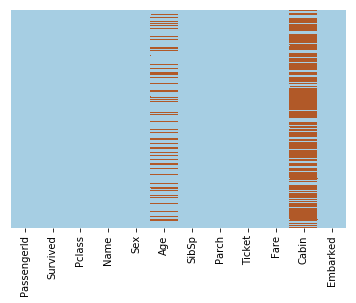

In [5]:
# Heatmap for visualising missing data:
sns.heatmap(titanic_train_df.isnull(), yticklabels = False, cbar = False, cmap = 'Paired')

In [6]:
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# Assign output PassengerId-s to the following variable:
passengerId = titanic_test_df['PassengerId']


In [8]:
# Merge train and test data into titanic and drop passengerId column:
titanic = titanic_train_df.append(titanic_test_df, ignore_index = True)
titanic = titanic.drop('PassengerId', axis = 1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


In [10]:
# Creating indexes to separate data later:
titanic_train_df_idx = len(titanic_train_df)
titanic_test_df_idx = len(titanic) - len(titanic_test_df)

Age

In [11]:
# We create new feature 'Title' there are 17 different titles used in names, so we map them to 6 main categories:
titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())


In [12]:
# Normalise the titles:
normalised_titles = {'Capt':'Officer','Col':'Officer','Major':'Officer', 'Jonkheer':'Royalty','Don':'Royalty',
                     'Sir':'Royalty', 'Dr':'Officer', 'Rev':'Officer', 'the Countess':'Royalty', 'Dona':'Royalty',
                     'Mme':'Mrs', 'Mlle':'Miss', 'Ms':'Mrs', 'Mr':'Mr', 'Mrs':'Mrs', 'Miss':'Miss', 'Master':'Master',
                     'Lady':'Royalty'}

In [13]:
# Map normalised titles to the current titles:
titanic['Title'] = titanic['Title'].map(normalised_titles)

In [14]:
# Group by Sex, Pclass and title:
group = titanic.groupby(['Sex', 'Pclass', 'Title'])

In [15]:
# To display mediang age by the groupped features:
group['Age'].median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [16]:
# Fill in the NaN age values by group median values:
titanic['Age'] = group['Age'].apply(lambda x: x.fillna(x.median()))

In [17]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


Ticket

In [18]:
#create function that takes ticket feature and returns list of ticket_type
import string

def ticket_sep(data_ticket):
    ticket_type = []

    for i in range(len(data_ticket)):

            ticket =data_ticket.iloc[i]

            for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
            if len(splited_ticket) == 1:
                ticket_type.append('NO')
            else: 
                ticket_type.append(splited_ticket[0])
    return ticket_type 

In [19]:
# for train data create new column with ticket_type:
titanic['ticket_type'] = ticket_sep(titanic.Ticket)


In [20]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,ticket_type
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr,A5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss,STONO2
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs,NO
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr,NO


NO         961
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
PP           4
WEP          4
SOTONO2      3
FC           3
SCA4         2
PPP          2
SC           2
SWPP         2
SP           1
SCA3         1
AQ4          1
A            1
CASOTON      1
AQ3          1
Fa           1
LP           1
SCOW         1
SOP          1
STONOQ       1
AS           1
Name: ticket_type, dtype: int64


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


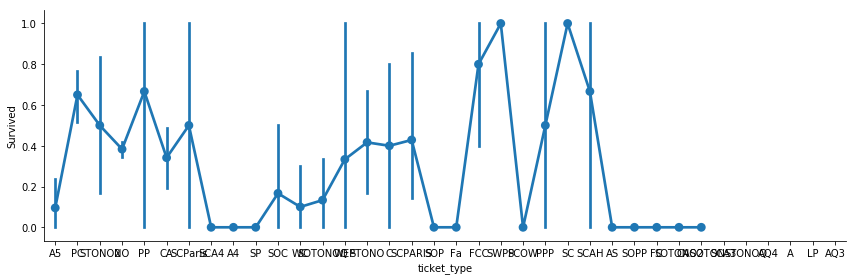

In [21]:
# check how many samples are there for each ticket type and visualize:
print(titanic["ticket_type"].value_counts())
sns.factorplot('ticket_type','Survived', data=titanic,size=4,aspect=3)

In [22]:
# for those types that have less than 15 samples in training set, assign type to 'OTHER':

for t in titanic['ticket_type'].unique():
    if len(titanic[titanic['ticket_type'] == t]) < 15:
        titanic.loc[titanic.ticket_type == t, 'ticket_type'] = 'OTHER_T'
       
    
for t in titanic['ticket_type'].unique():
    if t not in titanic['ticket_type'].unique():
        titanic.loc[titanic.ticket_type ==t, 'ticket_type'] = 'OTHER_T'
        
print(titanic['ticket_type'].unique())

['A5' 'PC' 'OTHER_T' 'NO' 'CA' 'WC' 'SOTONOQ']


In [23]:
# where ticket_type is 'SOTONOQ' convert it to 'A5'
titanic["ticket_type"] = np.where(titanic["ticket_type"]=='SOTONOQ', 'A5', titanic["ticket_type"])
titanic["ticket_type"] = np.where(titanic["ticket_type"]=='SOTONOQ', 'A5', titanic["ticket_type"])

NO         0.734148
OTHER_T    0.092437
PC         0.070283
CA         0.051948
A5         0.039725
WC         0.011459
Name: ticket_type, dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


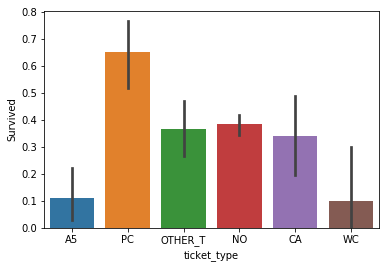

In [24]:
# visualize ticket_type vs survival rate
print(titanic["ticket_type"].value_counts()/len(titanic))
sns.barplot(x = 'ticket_type', y = 'Survived', data = titanic)

In [25]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
ticket_type    1309 non-null object
dtypes: float64(3), int64(3), object(7)
memory usage: 133.0+ KB


Embarked

In [26]:
# Fill in the NaN embarked values by the most frequent embarked:
most_embarked = titanic['Embarked'].value_counts().index[0]

titanic['Embarked'] = titanic['Embarked'].fillna(most_embarked)

Fare

In [27]:
# Fill NaN values for fare with median value:
titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].median())

Family

In [28]:
# introduce new column to data called family_size:
titanic['family_size'] = titanic.SibSp + titanic.Parch +1


# calculate survival rate for each family in train_set:
#rate_family = titanic.groupby('family')['Survived', 'family','family_size'].median()
#rate_family.head()

Cabin

In [29]:
# Set a new feature - Deck
titanic['Deck'] = titanic['Cabin'].str[0]
titanic['Deck'] = titanic['Deck'].fillna('U')

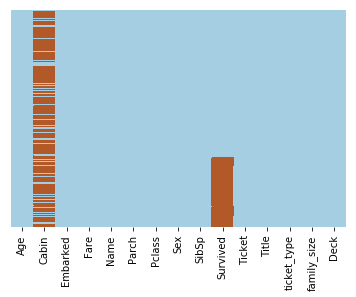

In [30]:
# Heatmap for visualising missing data:
sns.heatmap(titanic.isnull(), yticklabels = False, cbar = False, cmap = 'Paired') 

Sex

In [31]:
# Convert male and female groups to integer form:
titanic['Sex'] = titanic['Sex'].map({'male':0, 'female':1})

In [32]:
# Creating dummy variables for categorical features:
pclass_dummies = pd.get_dummies(titanic['Pclass'], prefix = 'Pclass')
title_dummies = pd.get_dummies(titanic['Title'], prefix = 'Title')
embarked_dummies = pd.get_dummies(titanic['Embarked'], prefix = 'Embarked')
ticket_dummies = pd.get_dummies(titanic['ticket_type'], prefix = 'Ticket')
cabin_dummies = pd.get_dummies(titanic['Deck'], prefix = 'Deck')

In [33]:
# Concatenate dummy columns with main dataset:
titanic1 = pd.concat([titanic, pclass_dummies, title_dummies, 
                      embarked_dummies, ticket_dummies, cabin_dummies], axis = 1)

In [34]:
titanic1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 42 columns):
Age               1309 non-null float64
Cabin             295 non-null object
Embarked          1309 non-null object
Fare              1309 non-null float64
Name              1309 non-null object
Parch             1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null int64
SibSp             1309 non-null int64
Survived          891 non-null float64
Ticket            1309 non-null object
Title             1309 non-null object
ticket_type       1309 non-null object
family_size       1309 non-null int64
Deck              1309 non-null object
Pclass_1          1309 non-null uint8
Pclass_2          1309 non-null uint8
Pclass_3          1309 non-null uint8
Title_Master      1309 non-null uint8
Title_Miss        1309 non-null uint8
Title_Mr          1309 non-null uint8
Title_Mrs         1309 non-null uint8
Title_Officer     1309 non-null uint8
Title_Ro

In [35]:
# Drop category fields:
titanic1 = titanic1.drop(['Title', 'Embarked', 'Name', 
                          'Ticket', 'Cabin', 'SibSp',
                          'Parch','ticket_type', 'Pclass', 'Deck'], axis = 1)

In [36]:
# Creating training and testing data:
training = titanic1[ : titanic_train_df_idx]
testing = titanic1[titanic_test_df_idx : ]

In [37]:
# Define input values, or X by dropping the Survived values:
X = training.drop(['Survived'], axis = 1)

# Define output values - this is the Survived feature:
y = training['Survived']

In [38]:
X.head()

,Age,Fare,Sex,family_size,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Ticket_A5,Ticket_CA,Ticket_NO,Ticket_OTHER_T,Ticket_PC,Ticket_WC,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,22.0,7.2500,0,2,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,26.0,7.9250,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,1,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,35.0,8.0500,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
# For splitting data we will be using train_test_split from sklearn:
from sklearn.model_selection import train_test_split

In [40]:
# Splitting the data into test and train, we are testing on 0.25 = 25% of dataset:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=13)

In [41]:
# Imports for training data:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forrest = RandomForestClassifier()

In [42]:
# Training the model:
forrest_params = dict(max_depth = [n for n in range(6,16)],
                      min_samples_split = [n for n in range(5,11)],
                      min_samples_leaf = [n for n in range(2,5)],
                      n_estimators = [n for n in range(10,60,10)],)

grid_forrest =  GridSearchCV(estimator = random_forrest, param_grid = forrest_params, cv = 4)

In [43]:
grid_forrest.fit(X,y)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_samples_split': [5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4], 'n_estimators': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
grid_forrest.best_params_

{'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 30}

In [45]:
forrest_params = grid_forrest.best_params_

In [46]:
y_predict = grid_forrest.predict(X)

In [47]:
##y_predict = xgb.predict(X)

In [48]:
len(y_predict)

891

In [49]:
len(y)

891

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y,y_predict)
cm

array([[518,  31],
       [ 81, 261]])

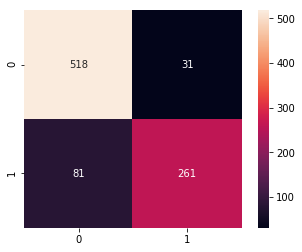

In [51]:
# Quick overview of our confusion matrix:
sns.heatmap(cm, annot = True, square = True, fmt='g')

In [52]:
print(classification_report(y,y_predict))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       549
         1.0       0.89      0.76      0.82       342

   micro avg       0.87      0.87      0.87       891
   macro avg       0.88      0.85      0.86       891
weighted avg       0.88      0.87      0.87       891



In [53]:
testing = testing.drop(['Survived'], axis = 1)

In [54]:
prediction = grid_forrest.predict(testing)

In [55]:
##prediction = xgb.predict(testing)

In [56]:
# Combine ImageID and Label into one DataFrame:
final_result = pd.DataFrame({'Survived': prediction, 'PassengerId': passengerId})
final_result['Survived'] = final_result['Survived'].astype(int) # convert everything to int values
final_result = final_result[['PassengerId', 'Survived']]

In [57]:
# Downloading final_result dataset as digit_output.csv:
final_result.to_csv('titanic_output.csv', index = False)